In [1]:
!pip install 'mahotas'

    100% |################################| 1.5MB 805kB/s eta 0:00:01
  Running setup.py bdist_wheel for mahotas ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
  Stored in directory: /home/nbuser/.cache/pip/wheels/86/11/ef/701934bfed4669cc956e33e7aaac92ea855f1126018067e431
Successfully built mahotas
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [144]:
import math
import pylab as p
import numpy as np
#import mahotas

### Define classes for Point, Wall and Room instances

In [205]:
class Point:
    x = 0
    y = 0
    z = 0
    
    assigned_wall = 0 #to which wall image point is assigned 

    def __init__(self, x_, y_, z_):
        self.x = x_
        self.y = y_
        self.z = z_

    def print(self):
        return '(' + str(self.x) + ',' + str(self.y) + ',' + str(self.z) + ')'

In [206]:
class Wall:
    wall_number = 0
    p1 = Point
    p2 = Point
    p3 = Point
    p4 = Point

    def __init__(self, p1_, p2_, p3_, p4_, num):
        self.wall_number = num
        self.p1 = Point(p1_.x, p1_.y, p1_.z)
        self.p2 = Point(p2_.x, p2_.y, p2_.z)
        self.p3 = Point(p3_.x, p3_.y, p3_.z)
        self.p4 = Point(p4_.x, p4_.y, p4_.z)

    def print(self):
        out = 'Wall ' + str(self.wall_number)
        out = out + ' ' + self.p1.print()
        out = out + ', ' + self.p2.print()
        out = out + ', ' + self.p3.print()
        out = out + ', ' + self.p4.print()
        return out

    # is the wall intersected
    def is_intersected(self, p):
        # horizontal
        if self.p1.x == self.p2.x:
            if (self.p1.x > p.x) or (self.p1.x == 0):
                return 0
            y = (self.p1.x * p.y) / p.x
            if (y >= self.p1.y) and (y < self.p2.y):
                return 1
        #vertical
        elif self.p1.y == self.p2.y:
            if (self.p1.y > p.y) or (self.p1.y == 0):
                return 0
            x = (self.p1.y * p.x) / p.y
            if (x >= self.p1.x) and (x < self.p2.x):
                return 1

        return 0

In [207]:
# Let's take 10x15x4 meters room

In [208]:
class Room:
    AP = Point(1,1,1)
    walls = []
                        
    def __init__(self):
        self.walls.append(Wall(Point(0,0,0), Point(15,0,0), Point(15,0,4), Point(0,0,4), 1))
        self.walls.append(Wall(Point(15,0,0), Point(15,10,0), Point(15,10,4), Point(15,0,4), 2))
        self.walls.append(Wall(Point(15,10,0), Point(0,10,0), Point(0,10,4), Point(15,10,4), 3))
        self.walls.append(Wall(Point(0,10,0), Point(0,0,0), Point(0,0,4), Point(0,10,4), 4))  
        
    def print(self):
        out = ''
        for w in self.walls:
            out = out + '\n' + w.print()
        return out

### Path loss

_**Notes**_  
The maximum number of reflections _n_ is set to 3

#### Base model [ARIADNE]

$$ P(d)[dB] = P(d_0)[dB] - 10*n*log_{10}\frac{d}{d_0} $$

where P(d) is the power at distance d to the transmitter in meters; P(d0) is the power at a reference distance d0, usually set to 1.0 meter. n is the attenuation exponent, which is often statistically determined to provide a best fit with measurement readings.
[ARIADNE]
Simple attenuation model is in the form of Equation 1, and it is the base model for the other models.

In [148]:
def path_loss(room):
    Pr = 0 # power received (dBm)
    Pt = -40.0 # transmit power at AP (dBm)
    n = 5.0 # attenuation exponent (dBm)
    d = .0 # distance
    d0 = 1.0 # reference distance

    PrArr = []

    # iterate over all blocks
    for x in range(0, 10):
        for y in range(0,10):
            P = Point(x, y) # initial point
            intersections = 0 # num of intersections with walls
            d = math.sqrt((x - AP.x)**2 + (y - AP.y)**2) # distance from the AP
            
            # check if there're any intersections
            for w in room.walls: 
                intersections += w.isIntersected(P)
                
            if d == 0:
                Pr = Pt
            else:
                log = math.log10(d/d0)
                Pr = Pt - 10*n*log
            PrArr.append(Pr)
            
            #Set boundaries for color:
            if Pr > -20.0:
                Pr = -20.0
            if Pr < -80.0:
                Pr = -80.0

            #Set the Red and Green values based on Pr:
            Pr += 20.0
            if Pr > -30.0:
                Green = 255
                Red = -Pr * 255.0 / 30.0
            else:
                Green = 255 + (Pr + 30) * 255.0 / 30.0
                Red = 255

            #Write the pixel's color to the data array:
            #setpixel(data, (x + BORD), (y + BORD), Red, Green, 0);

#### Radio propagation model [ARIADNE]

the model is defined as:
    $$ P = \sum^{N_{r,j}}_{i=1}{(P_0 - 20log_{10}(d_i) - \gamma N_{i, ref} - \alpha N_{i, trans})} $$

where P is the power (in dB) at receiver, $ N_{r,j} $ is the total number
of rays received at the receiver j; $ P_0 $ is the power (in dB) at
a distance of 1 meter; $ d_i $, $ N_{i,ref} $, and $ N_{i,trans} $ represent the total
transmission distance, the total number of reflections and the total
number of (wall) transmissions of the ith ray, respectively. Î³ is the
reflection coefficient, and Î± is the transmission coefficient.

The initial values can be any positive numbers, however, better values
will minimize the search time. Generally, better values can be derived
from literature.

### Visualization of a map

### Room generation

### Evaluation

#### A general comparison metric is the least mean square error (LMSE) [ARIADNE}

$$ D = min_N^{k=1}\{\frac{1}{n}(\sum^{n}_{i=1}(ss_{m,i,k} - ss_{i,k})^2)^\frac{1}{2}\} $$

where D is the least mean square error, N is the total number of
records in the signal strength map table, k denotes the kth record
in the SS-MAP table; n is the number of sniffers. ssm,i,k denotes
measured signal strength at sniffer i of the mobile user, and ssi,k is
the signal strength record at a sniffer i in SS-MAP table.

### Main 

### Image tree construction

#### "Last layer check" algorithm
#### "Surfaces on the same plane" algorithm is avoiding repeated calculation [useless in my case]

In [209]:
def is_intersected(image_point, Rx, wall):
    #if the wall is horizontal
    if wall.p1.y == wall.p2.y:
        if ((image_point.y > wall.p1.y) and (Rx.y < wall.p1.y)) or ((image_point.y < wall.p1.y) and (Rx.y > wall.p1.y)):
            return True
    #if the wall is vertical
    elif wall.p1.x == wall.p2.x:
        if ((image_point.x > wall.p1.x) and (Rx.x < wall.p1.x)) or ((image_point.x < wall.p1.x) and (Rx.x > wall.p1.x)):
            return True
    return False

In [210]:
def last_layer_check(layer_points, Rx, walls):
    checked_points = []
    for image_point in layer_points:
        wall = [w for w in walls if w.wall_number == image_point.assigned_wall][0]
        if is_intersected(image_point, Rx, wall):
            checked_points.append(image_point)

    return checked_points

In [211]:
# walls 1 and 3 - horizontal, 2 and 4 - vertical
def build_image_tree(Tx, Rx, walls):
    layer_points = []

    for wall in walls:
        #if the wall is horizontal
        if wall.p1.y == wall.p2.y:
            #if the wall is in front of the access point
            if wall.p1.y < Tx.y:
                #calculate image point
                x = Tx.x
                y = Tx.y - 2*abs(Tx.y - wall.p1.y)
                z = c
                layer_points.append(Point(x,y,z))
                layer_points[-1].assigned_wall = wall.wall_number
            #if the wall is behind the access point
            elif wall.p1.y >= Tx.y:
                #calculate image point
                x = Tx.x
                y = Tx.y + 2*abs(Tx.y - wall.p1.y)
                z = c
                layer_points.append(Point(x,y,z))
                layer_points[-1].assigned_wall = wall.wall_number

        #if the wall is vertical
        elif wall.p1.x == wall.p2.x:
            #if the wall is on the left
            if wall.p1.x < Tx.x:
                #calculate image point
                x = Tx.x - 2*abs(Tx.x - wall.p1.x)
                y = Tx.y
                z = c
                layer_points.append(Point(x,y,z))
                layer_points[-1].assigned_wall = wall.wall_number
            #if the wall is on the right
            elif wall.p1.x >= Tx.x:
                #calculate image point
                x = Tx.x + 2*abs(Tx.x - wall.p1.x)
                y = Tx.y
                z = c
                layer_points.append(Point(x,y,z))
                layer_points[-1].assigned_wall = wall.wall_number

    #check points on the last layer
    return last_layer_check(layer_points, Rx, walls)

In [212]:
c = 1
room = Room()
Tx = Point(2,5,c)
Rx = Point(11,3,c)
image_tree = []
image_tree.append(Tx)
image_tree.append(build_image_tree(Tx, Rx, room.walls))

In [214]:
for m in image_tree[1]:
    print(m.print())

(2,-5,1)
(28,5,1)
(2,15,1)
(-2,5,1)


## Tests

In [24]:
import math
import numpy as np



__all__ = [
    'plane_earth', 
    'friis',
    'interference', 
    'log_distance',
    'dual_slope'
]



def plane_earth(d, htx, hrx):
    """
    Deterministic two-ray model to account for line-of-sight and ground
    reflected paths
    
    Args
    ----
    d : flt or array_like
        Transmitter/receiver separation {km}
        
    htx, hrx : flt, flt
        Transmitter/receiver height {m}
        
    Returns
    -------
    L : flt or array_like
        Path loss {dB}
    """
    return 40.*np.log10(d*1e3) - 20.*math.log10(htx) - 20.*math.log10(hrx)



def friis(d, f, crossover=False, **kwargs):
    """ 
    Friis path loss formula for free-space propagation
    
    Args
    ----
    d : flt or array_like
        Transmitter to receiver separation {km}
    
    f : flt
        Transmit frequency {MHz}
    
    crossover : bool
        Flag for using plane earth model in far-field
    
    Keyword Args
    ------------
    htx, hrx : flt, flt
        Transceiver/receiver height {m, m} if `crossover` is True
      
    Return
    -------
    L : 1D array, size of `d`
        Path loss {dB}
    """  
    d = np.ravel(d)
    L = 20.*np.log10(d) + 20.*math.log10(f) + 32.44
    
    if crossover and {'htx','hrx'}.issubset(kwargs):
        htx, hrx = kwargs['htx'], kwargs['hrx']
        wv = 3e2/f
        dc = 4.*math.pi*htx*hrx/wv
        dc /= 1000. # crossover distance in km
        L[d>dc] = plane_earth(d[d>dc], htx, hrx)
        
    return L



def interference(d, f, htx, hrx, epsilon=1.):
    """
    Deterministic model to account for phase difference of interfering rays and
    ground permittivity
    
    Args
    ----
    d : flt or array_like
        Transmitter/receiver separation {km}
    
    f : flt
        Transmit frequency {MHz}
    htx, hrx : flt, flt
        Transmitter/receiver height {m}  
    
    epsilon : flt, optional
        Ground permittivity. Default is 1 for free space propagation
    
    Returns
    -------
    L : 1D array, size of `d`
        Path loss {dB}
    """
    r = d*1e3  # separation in meters
    a = np.array([r, htx-hrx])
    b = np.array([r, htx+hrx])
    dlos = np.linalg.norm(a) 
    dref = np.linalg.norm(b)
    s, c = (htx+hrx)/dref, r/dref    
    
    psi = 2*math.pi*(dlos-dref)*f/3e2  # phase term
    X = np.sqrt(epsilon - c**2.)  
    gamma = (s-X)/(s+X)  # ground reflection coeffecient
    
    L0 = friis(d, f, crossover=False)
    return L0 - 20*np.log10(np.abs(1+gamma*np.exp(1j*psi)))
    


def log_distance(d, f, gamma, d0=1., sigma=0.):
    """
    Simplified empirical model for path loss inside buildings or densely 
    populated areas
    
    Args
    ----
    d : flt or array_like
        Transmitter to receiver separation {km}
    
    f : flt
        Transmit frequency {MHz}
    gamma : flt
        Path loss exponent
    
    d0 : flt, optional
        Reference distance {km}
    
    sigma : flt, optional
        Standard deviation of zero-mean Gaussian distributed random variable 
        to account for signal shadowing {dB}
    Returns
    -------
    L : 1D array, size of `d`
        Path loss {dB}
    """
    d = np.ravel(d).astype(float)
    L0 = friis(d0, f)
    if sigma > 0.:
        Xg = np.random.normal(scale=sigma, size=d.size)
    else:
        Xg = 0.
    return L0 + gamma*10.*np.log10(d/d0) + Xg



def dual_slope(d, f, htx, hrx, gamma, d0=1.):
    """
    Dual slope emprical model for first Fresnel zone obstruction in
    line-of-sight topographies 
    
    Args
    ----
    d : flt or array_like
        Transmitter/receiver separation {km}
    
    f : flt
        Transmit frequency {MHz}
    htx, hrx : flt, flt
        Transmitter/receiver height {m}  
        
    gamma : array_like, len=2
        Path loss exponents 
    
    d0 : flt, optional
        Reference distance {km}
    
    Returns
    -------
    L : 1D array, size of `d`
        Path loss {dB}
    """
    d = np.ravel(d).astype(float)
    wv = 3e2/f
    Sigma, Delta = (htx+hrx)**2., (htx-hrx)**2.
    df = math.sqrt((Sigma-Delta)**2. - 2.*(Sigma+Delta)*(wv/2.)**2. + (wv/2.)**4.)/wv
    df /= 1000.  # Fresnel zone break point in km
    
    L = np.empty_like(d)
    L[d<=df] = log_distance(d[d<=df], f, gamma[0], d0=d0)
    L[d>df] = log_distance(df, f, gamma[0], d0=d0) + gamma[1]*10.*np.log10(d[d>df]/df) 
    
    return L

In [25]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
matplotlib.rc('font', family='STIXGeneral', size=17)

## Local imports
#from path_loss import *


if __name__ == '__main__':
    
    examples = [1, 2]
    savefigs = False
    
    if 1 in examples:
        
        f = 1500.   
        r = np.logspace(1,4.5,1e4) 
        d = r*1e-3
        hrx = 1.5
        htx = 10.
        
        L_plane_earth = plane_earth(d, htx, hrx)
        L_interference = interference(d, f, htx, hrx, epsilon=15)
        L_friis = friis(d, f)
        L_xover = friis(d, f, crossover=True, htx=htx, hrx=hrx)
        L_ds = dual_slope(d, f, htx, hrx, gamma=(2,4), d0=r[0])
            
        plt.figure(figsize=(8,6))
        ax = plt.axes()
    
        plt.title("Path loss models")
        plt.ylabel("Path loss (-dB)"), plt.xlabel("d (m)")
        
        plt.semilogx(r, 
                     -L_interference,
                     c='blue',
                     lw=1.5,
                     ls='-',
                     label="Two-ray interference")  
        
        plt.semilogx(r,
                     -L_ds,
                     c='forestgreen',
                     lw=2,
                     ls='--',
                     label="Fresnel interference")
                     
        plt.semilogx(r, 
                     -L_friis,
                     c='k',
                     lw=1, 
                     ls='-.') #label="Free space, $\gamma=2$") 
      
        plt.semilogx(r, 
                     -L_plane_earth,
                     c='k',
                     lw=1, 
                     ls='-.') # label="Two-ray ground, $\gamma=4$")
                     

#        ax.annotate('$\propto r^{-4}$', xy=(100,-55))     
#        ax.annotate('$\propto r^{-2}$', xy=(1e4,-113))
        
        plt.xlim(r.min(), r.max())
        plt.legend(fontsize=15)
        plt.grid('on', which="both")
        if savefigs:
            plt.savefig('interference.png',
                        bbox_inches='tight',
                        pad_inches=0.05)
    
    
    
    if 2 in examples:
        
        f = 1500.
        r = np.logspace(2,4, 1e4)
        d = r*1e-3
        hrx = 1.5
        htx = 10.
        
        L1 = log_distance(d, f, 2, d0=.1)
        L1_sh = log_distance(d, f, 2, sigma=0.5, d0=.1)
        
        L2 = log_distance(d, f, 3.5, d0=.1)
        L2_sh = log_distance(d, f, 3.5, sigma=3, d0=.1)
        
        plt.figure(figsize=(8,5))
        plt.title("Emprical model")
        plt.ylabel("Path Loss (-dB)"), plt.xlabel("d (m)")
        
        plt.semilogx(r,
                    -L1,
                    c='k',
                    lw=2,
                    ls='--',
                    label="Open air")
        
        plt.semilogx(r,
                    -L1_sh,
                    c='forestgreen',
                    lw=1,
                    ls='-',
                    alpha=.3)
        
        plt.semilogx(r,
                     -L2,
                     c='darkblue',
                     lw=2,
                     ls='-.',
                     label="Textile")

        plt.semilogx(r,
                    -L2_sh,
                    c='b',
                    lw=1,
                    ls='-',
                    alpha=.3)
                    
        plt.xlim(r.min(), r.max())
        plt.legend(fontsize=15)
        plt.grid('on', which='both')
        if savefigs:
            plt.savefig('empirical.png',
                        bbox_inches='tight',
                        pad_inches=0.05)

[  1.00000000e+01   1.00080631e+01   1.00161327e+01 ...,   3.15718427e+04
   3.15972994e+04   3.16227766e+04]

8.5


ValueError: setting an array element with a sequence.

In [134]:
#test
PrArr = []
points = []
points.append(Point(15,10))
#points.append(Point(1,0))
#points.append(Point(2,0))
#points.append(Point(3,0))

for p in points:
    P = Point(p.x, p.y) # initial point
    intersections = 0 # num of intersections with walls
    d = math.sqrt((p.x - AP.x)**2 + (p.y - AP.y)**2); # distance from the AP
    # check if there're any intersections
    for w in walls: #range(0, len(walls)):
        intersections += w.isIntersected(P)
    if(d == 0):
        Pr = Pt
    else:
        log = math.log10(d/d0)
        Pr = Pt - 10*n*log
    PrArr.append(Pr)

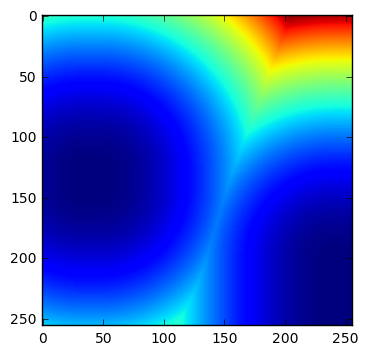

In [23]:
import pylab as p
import numpy as np
import mahotas

f = np.ones((256,256), bool)
f[200:,240:] = False
f[128:144,32:48] = False
# f is basically True with the exception of two islands: one in the lower-right
# corner, another, middle-left

dmap = mahotas.distance(f)
p.imshow(dmap)
p.show()